# Section 3 Porject
## 주제 
> 피부암의 사망률은 75%로 흔한 질환이다. 이를 빠르게 선별진료하는 것은 생존율에 많은 영향을 준다. 이에 본 프로젝트는 피부암을 빠르게 선별할 수 있는 딥러닝 모델을 만드는 것을 목표로 한다.


## 주제 선정 이유
> 헬스케어 관련 이미지 분석에서 가장 유명한 피부암 판별 주제를 통해서 헬스케어 이미지 분석에 대해 공부해볼 생각이다. 또한 스마트폰을 이용해 가정에서 피부암이나 피부에난 상처들을 진단하여 적절한 치료를 받을 수 있도록 서비스를 제공한다.


## 과정
1. 데이터셋 불러오기
2. 데이터 전처리
3. 모델 제작
4. 모델 성능 비교


In [47]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import os
import cv2 
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.image import pad_to_bounding_box
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from PIL import Image

In [48]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [49]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Project 3/ISIC_2020_Training_GroundTruth.csv')
df

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0
...,...,...,...,...,...,...,...,...
33121,ISIC_9999134,IP_6526534,male,50.0,torso,unknown,benign,0
33122,ISIC_9999320,IP_3650745,male,65.0,torso,unknown,benign,0
33123,ISIC_9999515,IP_2026598,male,20.0,lower extremity,unknown,benign,0
33124,ISIC_9999666,IP_7702038,male,50.0,lower extremity,unknown,benign,0


In [50]:
np.random.seed(42)
tf.random.set_seed(42)

# 데이터 정보

## columns 정보
* image_name- 고유 식별자, 관련 DICOM 이미지의 파일 이름을 가리킴
* patient_id - 고유한 환자 식별자
* sex- 환자의 성별(알 수 없는 경우 공란)
* age_approx - 촬영 당시의 대략적인 환자 나이
* anatom_site_general_challenge - 이미지 촬영 신체 위치
* diagnosis - 상세진단정보(열차만 해당)
* benign_malignant - 촬영된 병변의 악성 지표
* target - 대상 변수의 이진화 버전





In [51]:
df.isnull().sum()

image_name                         0
patient_id                         0
sex                               65
age_approx                        68
anatom_site_general_challenge    527
diagnosis                          0
benign_malignant                   0
target                             0
dtype: int64

In [52]:
df.duplicated().sum()

0

In [53]:
lis = ['sex','anatom_site_general_challenge','diagnosis','target']
for i in lis:
  print(i)
  print(df[i].value_counts())
  print('='*30)

sex
male      17080
female    15981
Name: sex, dtype: int64
anatom_site_general_challenge
torso              16845
lower extremity     8417
upper extremity     4983
head/neck           1855
palms/soles          375
oral/genital         124
Name: anatom_site_general_challenge, dtype: int64
diagnosis
unknown                               27124
nevus                                  5193
melanoma                                584
seborrheic keratosis                    135
lentigo NOS                              44
lichenoid keratosis                      37
solar lentigo                             7
cafe-au-lait macule                       1
atypical melanocytic proliferation        1
Name: diagnosis, dtype: int64
target
0    32542
1      584
Name: target, dtype: int64


In [54]:
df['target'].value_counts(normalize =True) # 0: 양성 pos / 1: 악성 mel

0    0.98237
1    0.01763
Name: target, dtype: float64

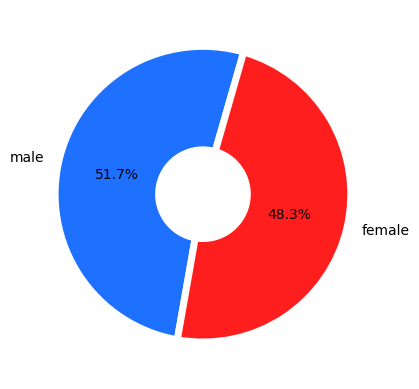

In [55]:
counts = df['sex'].value_counts()
wedgeprops={'width': 0.7, 'edgecolor': 'w', 'linewidth': 5}
colors= ['#1E70FF','#FF1E1E']
plt.pie(counts, labels=counts.index, autopct='%.1f%%', startangle=260, counterclock=False,colors=colors, wedgeprops=wedgeprops)
plt.show()

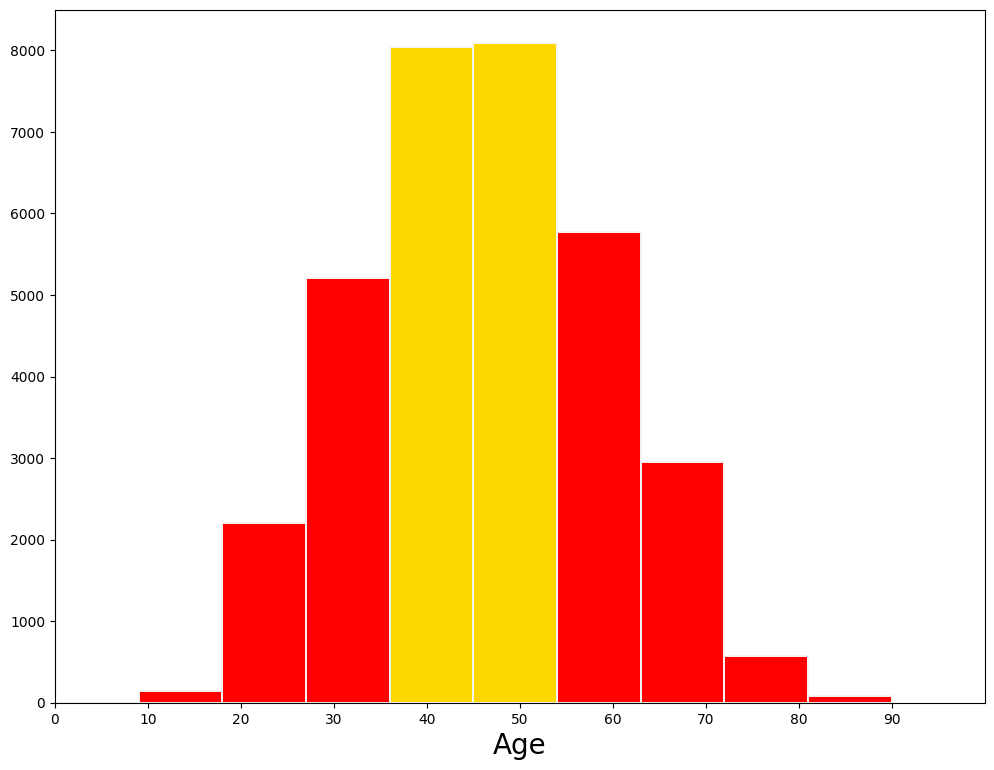

In [56]:
df['age'] = df['age_approx'].apply(lambda x : (x//10)*10)
counts = df['age'].value_counts().sort_index()
counts
plt.figure(figsize=(12,9))
plt.xlabel('Age', fontsize=20)
plt.xlim([0,100])
plt.xticks(range(0, 100,10))
n, bins, patches = plt.hist(df['age']
         ,color = '#FF0000'
         ,edgecolor = 'whitesmoke'
         ,linewidth = 1.4
         )

for i in range(4, 6): 
    patches[i].set_facecolor('gold') 

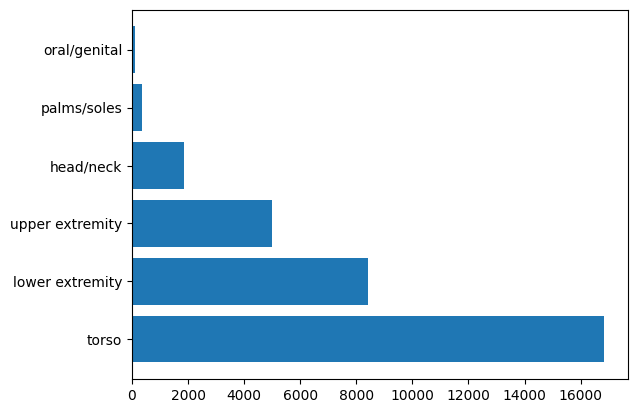

In [57]:
x = df['anatom_site_general_challenge'].value_counts()
plt.barh(x.index, x)
plt.show()

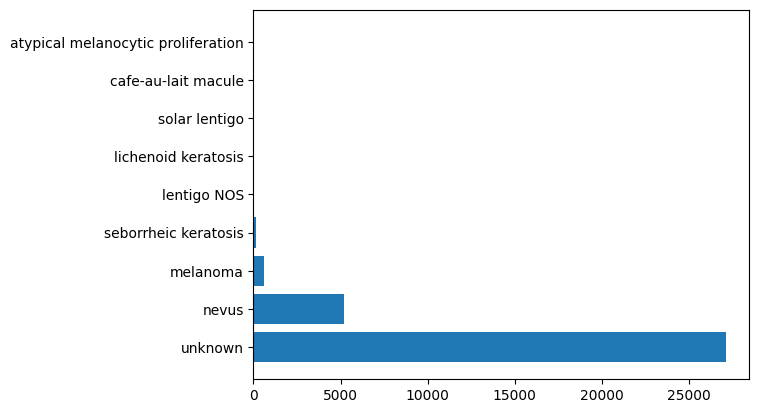

In [58]:
x = df['diagnosis'].value_counts()
plt.barh(x.index, x)
plt.show()

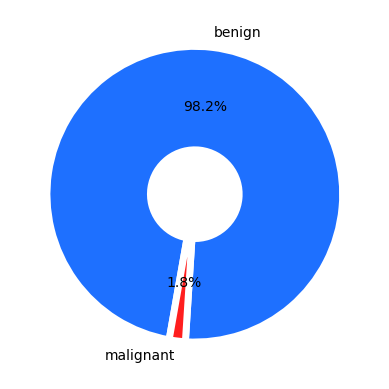

In [59]:
counts = df['benign_malignant'].value_counts()
wedgeprops={'width': 0.7, 'edgecolor': 'w', 'linewidth': 5}
colors= ['#1E70FF','#FF1E1E']
plt.pie(counts, labels=counts.index, autopct='%.1f%%', startangle=260, counterclock=False,colors=colors, wedgeprops=wedgeprops)
plt.show()

# 이미지 파일 전처리

In [60]:
label = ['image_name','target']
df_label = df[label]
df_label

,image_name,target
0,ISIC_2637011,0
1,ISIC_0015719,0
2,ISIC_0052212,0
3,ISIC_0068279,0
4,ISIC_0074268,0
...,...,...
33121,ISIC_9999134,0
33122,ISIC_9999320,0
33123,ISIC_9999515,0
33124,ISIC_9999666,0


In [61]:
image_name = list(df_label['image_name'])
mel = df_label[df_label['target'] == 1]
pos = df_label[df_label['target'] == 0]

pos_list = list(pos['image_name'])
mel_list = list(mel['image_name'])

train_mel, val_mel = train_test_split(mel, test_size=0.2, random_state=42)
train_pos, val_pos = train_test_split(pos, test_size=0.2, random_state=42)

# train
train_pos = list(train_pos['image_name'])
train_mel = list(train_mel['image_name'])

# val
val_pos = list(val_pos['image_name'])
val_mel = list(val_mel['image_name'])

print('train :', len(train_pos), len(train_mel))
print('val :', len(val_pos), len(val_mel))

train : 26033 467
val : 6509 117


In [62]:
base_dir = '/content/drive/MyDrive/Colab Notebooks/Project 3/Data_train/train'
basename = os.listdir(base_dir)
len(basename)

33126

In [63]:
# 파일 생성
'''
x_dir = '/content/drive/MyDrive/Colab Notebooks/Project 3/Data_train'
x_train_dir = os.path.join(x_dir,'X_train')
os.mkdir(x_train_dir)
'''
x_dir = '/content/drive/MyDrive/Colab Notebooks/Project 3/Data_train/X_train'
'''
pos_dir = os.path.join(x_dir,'positive')
mel_dir = os.path.join(x_dir, 'melignant')

os.mkdir(pos_dir)
os.mkdir(mel_dir)
'''

"\npos_dir = os.path.join(x_dir,'positive')\nmel_dir = os.path.join(x_dir, 'melignant')\n\nos.mkdir(pos_dir)\nos.mkdir(mel_dir)\n"

In [64]:
import shutil
# 파일 경로 이동

def move_file(base_dir,data_dir, name_list):
  os.chdir(base_dir)
  for name in name_list:
    name_jpg = name+'.jpg'
    shutil.move(name_jpg,data_dir)

  return len(os.listdir(data_dir))

In [65]:
# 파일 복사 이동
def copy_file(base_dir,data_dir, name_list):
  os.chdir(base_dir)
  for name in name_list:
    name_jpg = name+'.jpg'
    shutil.copy2(name_jpg,data_dir)

  return len(os.listdir(data_dir))

In [66]:
base_dir = '/content/drive/MyDrive/Colab Notebooks/Project 3/Data_train/train'
mel_dir = '/content/drive/MyDrive/Colab Notebooks/Project 3/Data_train/X_train/melignant'
pos_dir = '/content/drive/MyDrive/Colab Notebooks/Project 3/Data_train/X_train/positive'

In [68]:
len(os.listdir(pos_dir))

26033

In [69]:
# 파일 업로드 과정에서 많은 데이터량으로 인한 리스트 업데이트 
def update_list(dir,name_list):
  update_list = []
  inlist = os.listdir(dir)
  for name in name_list:
    name_jpg = name+'.jpg'
    if name_jpg not in inlist:
      update_list.append(name)
  
  return update_list

In [70]:
'''
train_pos2 = update_list(pos_dir,train_pos)
len(train_pos2)
>> 586
'''

'\ntrain_pos2 = update_list(pos_dir,train_pos)\nlen(train_pos2)\n>> 586\n'

In [71]:
# train list : train_pos / train_mel
'''
copy_file(base_dir,pos_dir,train_pos2)
>> 26033
copy_file(base_dir,mel_dir,train_mel)
>> 467
'''

'\ncopy_file(base_dir,pos_dir,train_pos2)\n>> 26033\ncopy_file(base_dir,mel_dir,train_mel)\n>> 467\n'

In [72]:
val_mel_dir ='/content/drive/MyDrive/Colab Notebooks/Project 3/Data_train/val/mel'
val_pos_dir ='/content/drive/MyDrive/Colab Notebooks/Project 3/Data_train/val/pos'

# val list : val_pos / val_mel
'''
copy_file(base_dir,val_mel_dir,val_mel)
>> 117
copy_file(base_dir,val_pos_dir,val_pos)
>> 6509
'''

'\ncopy_file(base_dir,val_mel_dir,val_mel)\n>> 117\ncopy_file(base_dir,val_pos_dir,val_pos)\n>> 6509\n'

# 이미지 불러오기

In [73]:
train_dir ='/content/drive/MyDrive/Colab Notebooks/Project 3/Data_train/X_train'
val_dir = '/content/drive/MyDrive/Colab Notebooks/Project 3/Data_train/val'

In [74]:
df_train = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(256,256),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False
)


df_val = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(256,256),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False
)

Found 26500 files belonging to 2 classes.
Found 6626 files belonging to 2 classes.


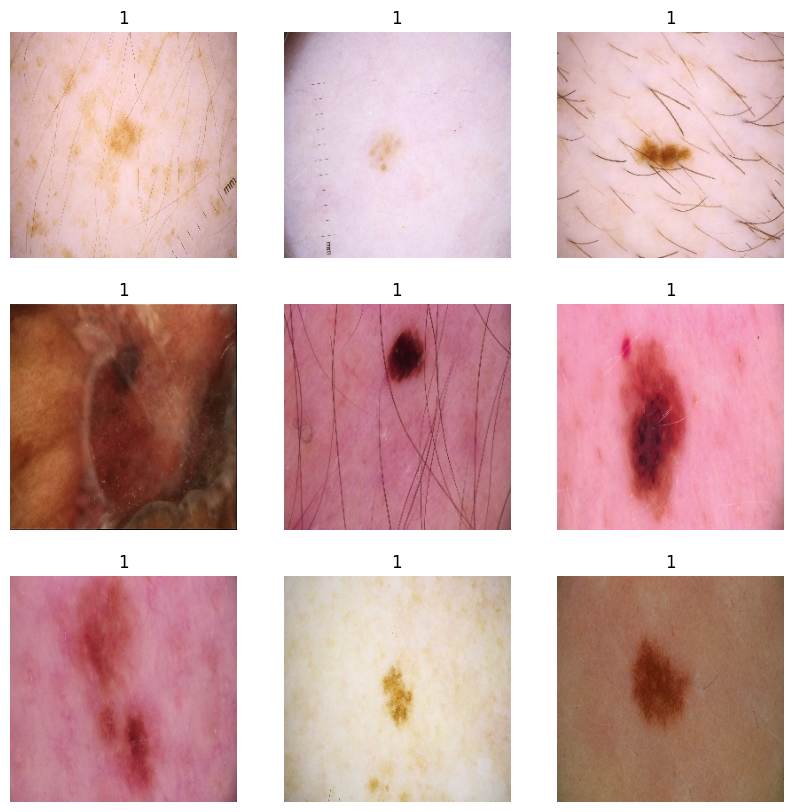

In [75]:
plt.figure(figsize=(10, 10))

# 배치 하나를 가져옵니다.
for images, labels in df_train.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

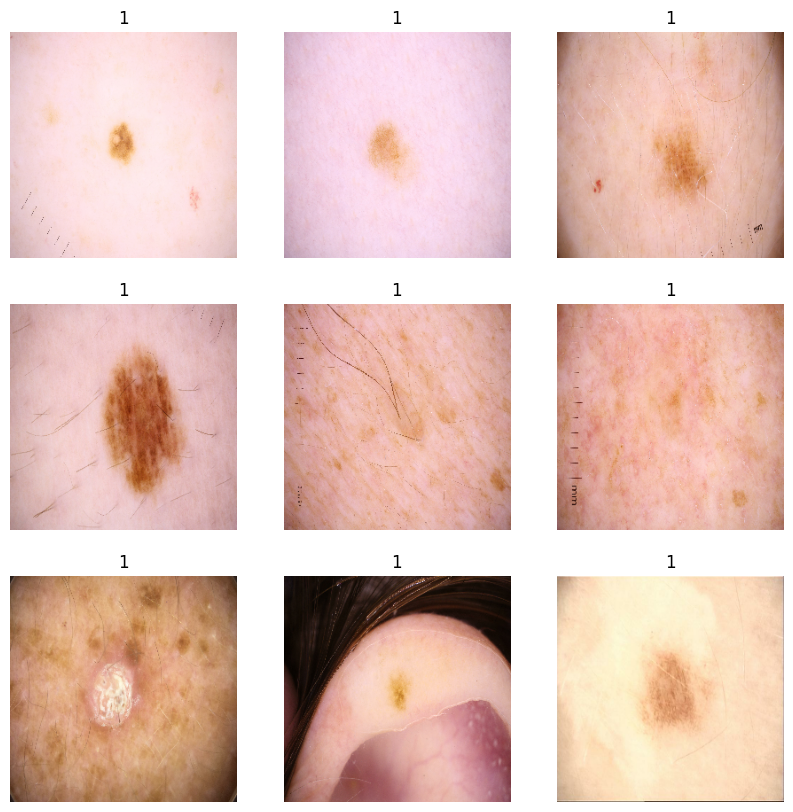

In [76]:
plt.figure(figsize=(10, 10))

for images, labels in df_val.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

# 신경망 구성

In [77]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon May 15 01:02:34 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    27W /  70W |    439MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [78]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import numpy as np
from tqdm import tqdm
import math
import os

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.callbacks import *
from tensorflow.keras import backend as K
K.clear_session()
import itertools
import matplotlib.pyplot as plt
import cv2
import matplotlib.cm as cm

from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer,LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


In [79]:
# 참고 모델
def make_model(input_shape):
  inputs = keras.Input(shape=input_shape)
  data_augmentation = keras.Sequential([layers.experimental.preprocessing.RandomFlip('horizontal'),
                        layers.experimental.preprocessing.RandomRotation(0.1),
                        ])
  x = data_augmentation(inputs)
  
  x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
  x = layers.Conv2D(32,3,strides=2, padding='same')(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation('relu')(x)

  x = layers.Conv2D(64,3, padding='same')(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation('relu')(x)

  previous_block_activation = x

  for size in [128, 256, 512]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

  x = layers.SeparableConv2D(1024, 3, padding="same")(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation("relu")(x)

  x = layers.GlobalAveragePooling2D()(x)
  x = layers.Dropout(0.5)(x)
  outputs = layers.Dense(1,activation='sigmoid')(x)

  return keras.Model(inputs,outputs)

image_size = (256,256)
model = make_model(input_shape=image_size + (3,))

In [80]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy']) 

In [81]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 256, 256, 3)  0           ['input_1[0][0]']                
                                                                                                  
 rescaling (Rescaling)          (None, 256, 256, 3)  0           ['sequential[0][0]']             
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 32  896         ['rescaling[0][0]']          

In [ ]:
model.fit(df_train,
          batch_size=2650,
          validation_data=(df_val),
          epochs=10)

Epoch 1/10
829/829 [==============================] - 1013s 1s/step - loss: 0.0909 - accuracy: 0.9816 - val_loss: 0.0811 - val_accuracy: 0.9823
Epoch 2/10
829/829 [==============================] - 1006s 1s/step - loss: 0.0846 - accuracy: 0.9823 - val_loss: 0.2101 - val_accuracy: 0.9786
Epoch 3/10
829/829 [==============================] - 992s 1s/step - loss: 0.0836 - accuracy: 0.9823 - val_loss: 0.0900 - val_accuracy: 0.9823
Epoch 4/10
829/829 [==============================] - 992s 1s/step - loss: 0.0834 - accuracy: 0.9823 - val_loss: 0.0863 - val_accuracy: 0.9823
Epoch 5/10
829/829 [==============================] - 1007s 1s/step - loss: 0.0819 - accuracy: 0.9823 - val_loss: 0.0791 - val_accuracy: 0.9823
Epoch 6/10
829/829 [==============================] - 988s 1s/step - loss: 0.0817 - accuracy: 0.9824 - val_loss: 0.0901 - val_accuracy: 0.9823
Epoch 7/10
829/829 [==============================] - 1002s 1s/step - loss: 0.0810 - accuracy: 0.9823 - val_loss: 0.0818 - val_accuracy: 0.

In [ ]:
test_dir ='/content/drive/MyDrive/Colab Notebooks/Project 3/test'
test = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(256,256),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False
)

model.evaluate(test, verbose=2)

Found 0 files belonging to 0 classes.


ValueError: ignored

In [ ]:
'''
model.fit(df_train,
          batch_size=2650,
          validation_data=(df_val),
          epochs=10)
>>
Epoch 1/10
829/829 [==============================] - 1631s 2s/step - loss: 0.0946 - accuracy: 0.9791 - val_loss: 0.1025 - val_accuracy: 0.9823
Epoch 2/10
667/829 [=======================>......] - ETA: 2:34 - loss: 0.0853 - accuracy: 0.9820
'''

'\nmodel.fit(df_train,\n          batch_size=2650,\n          validation_data=(df_val),\n          epochs=10)\n>>\nEpoch 1/10\n829/829 [==============================] - 1631s 2s/step - loss: 0.0946 - accuracy: 0.9791 - val_loss: 0.1025 - val_accuracy: 0.9823\nEpoch 2/10\n667/829 [=======================>......] - ETA: 2:34 - loss: 0.0853 - accuracy: 0.9820\n'